# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits! We will use the loss functions and models we built in the previous exercises.


The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
>* The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
>* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<p align="center">
    <img src='../../images/gan_pipeline.png' width="500" height="auto" />
</p>

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

In this notebook, we will be using the [MNIST Dataset](http://yann.lecun.com/exdb/mnist/), a dataset of handwritten digits. We can use the torch [Datasets API](https://pytorch.org/vision/stable/datasets.html) to load the whole dataset directly. The MNIST dataset is made of 28x28 grayscale images.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 128

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

We visualize a single random example of the MNIST dataset. You can rerun this cell multiple times to see different logits.

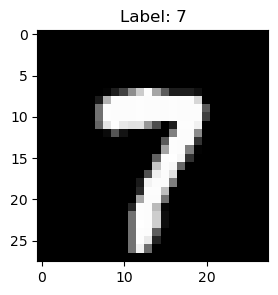

In [3]:
# obtain one batch of training images
rand_index = np.random.randint(0, len(train_data), 1)[0]
images = train_data[rand_index][0]
label = train_data[rand_index][1]
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator. In this exercise, we will be using the Generator and Discriminator we previously built.

## Discriminator

In [5]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_size: int, hidden_dim: int):
        super(Discriminator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        
        # define the final layer
        self.fc4 = nn.Linear(hidden_dim // 4, 1)        
        
        # define the dropout
        self.dropout = nn.Dropout(0.3)
        
        # define the activation
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # flatten image
        x = x.view(-1, 28*28)
        
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # we are using BCE with logits loss so the last activation is not required
        x = self.fc4(x)
        return x

## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_size: int):
        super(Generator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # define the activation
        self.activation = nn.LeakyReLU(0.2)
        self.final_activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.activation(x)

        x = self.fc2(x)
        x = self.activation(x)

        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        x = self.final_activation(x)
        return x

## Model hyperparameters

In [7]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of last hidden layer in the discriminator
d_hidden_size = 128

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [8]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (final_activation): Tanh()
)


---
## Discriminator and Generator Losses

Now we need to calculate the losses. For this exercise, we will use the loss functions we previously implemented. 

In [9]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [10]:
import torch.optim as optim

# Optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [11]:
from datetime import datetime
import pickle as pkl

# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()

2025-05-22 20:20:10 | Epoch [1/10] | Batch 0/469 | d_loss: 1.3890 | g_loss: 0.7004
2025-05-22 20:20:10 | Epoch [1/10] | Batch 100/469 | d_loss: 1.1911 | g_loss: 0.7239
2025-05-22 20:20:10 | Epoch [1/10] | Batch 200/469 | d_loss: 0.7346 | g_loss: 1.3298
2025-05-22 20:20:11 | Epoch [1/10] | Batch 300/469 | d_loss: 0.8100 | g_loss: 1.0966
2025-05-22 20:20:11 | Epoch [1/10] | Batch 400/469 | d_loss: 0.7541 | g_loss: 1.3509


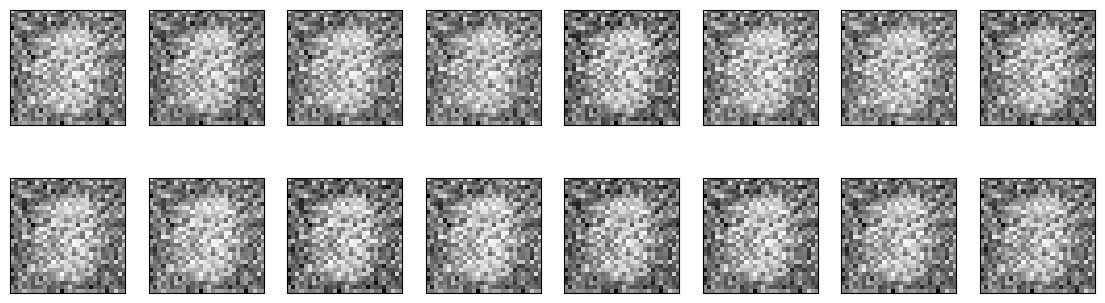

2025-05-22 20:20:13 | Epoch [2/10] | Batch 0/469 | d_loss: 0.5699 | g_loss: 1.8542
2025-05-22 20:20:14 | Epoch [2/10] | Batch 100/469 | d_loss: 0.5337 | g_loss: 2.3494
2025-05-22 20:20:14 | Epoch [2/10] | Batch 200/469 | d_loss: 0.4394 | g_loss: 3.3028
2025-05-22 20:20:15 | Epoch [2/10] | Batch 300/469 | d_loss: 0.5158 | g_loss: 3.4700
2025-05-22 20:20:15 | Epoch [2/10] | Batch 400/469 | d_loss: 0.4393 | g_loss: 3.6388


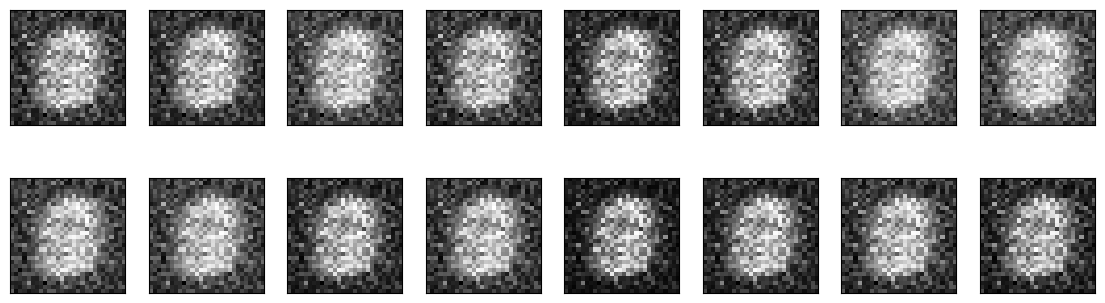

2025-05-22 20:20:17 | Epoch [3/10] | Batch 0/469 | d_loss: 0.6344 | g_loss: 2.8249
2025-05-22 20:20:17 | Epoch [3/10] | Batch 100/469 | d_loss: 0.7920 | g_loss: 2.2383
2025-05-22 20:20:18 | Epoch [3/10] | Batch 200/469 | d_loss: 0.4979 | g_loss: 4.8854
2025-05-22 20:20:18 | Epoch [3/10] | Batch 300/469 | d_loss: 0.5055 | g_loss: 4.2898
2025-05-22 20:20:18 | Epoch [3/10] | Batch 400/469 | d_loss: 0.4519 | g_loss: 4.2096


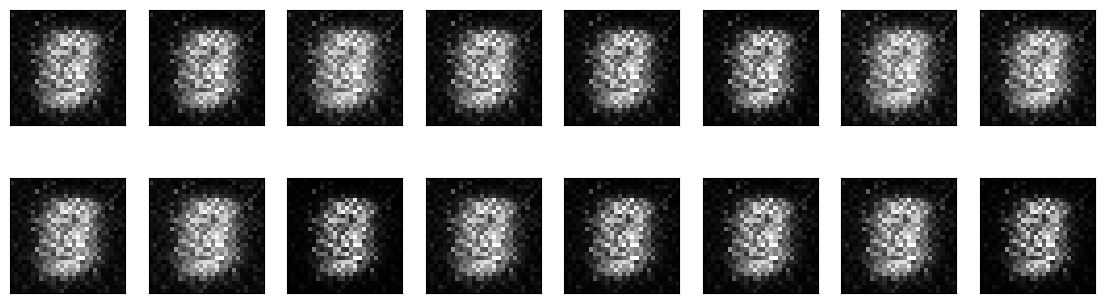

2025-05-22 20:20:20 | Epoch [4/10] | Batch 0/469 | d_loss: 0.5496 | g_loss: 2.9495
2025-05-22 20:20:21 | Epoch [4/10] | Batch 100/469 | d_loss: 0.7367 | g_loss: 2.5824
2025-05-22 20:20:21 | Epoch [4/10] | Batch 200/469 | d_loss: 0.6136 | g_loss: 3.4862
2025-05-22 20:20:21 | Epoch [4/10] | Batch 300/469 | d_loss: 0.4399 | g_loss: 4.7312
2025-05-22 20:20:22 | Epoch [4/10] | Batch 400/469 | d_loss: 0.4486 | g_loss: 4.5718


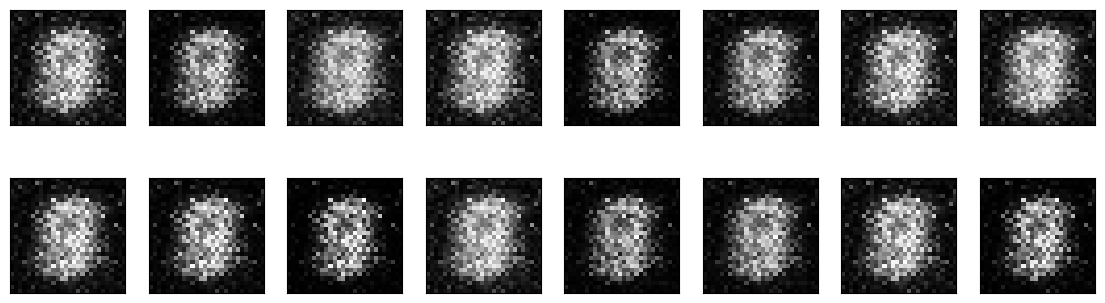

2025-05-22 20:20:24 | Epoch [5/10] | Batch 0/469 | d_loss: 0.4939 | g_loss: 2.8710
2025-05-22 20:20:24 | Epoch [5/10] | Batch 100/469 | d_loss: 0.4752 | g_loss: 4.1930
2025-05-22 20:20:25 | Epoch [5/10] | Batch 200/469 | d_loss: 0.4189 | g_loss: 5.0425
2025-05-22 20:20:25 | Epoch [5/10] | Batch 300/469 | d_loss: 0.4907 | g_loss: 4.5868
2025-05-22 20:20:25 | Epoch [5/10] | Batch 400/469 | d_loss: 0.5861 | g_loss: 4.0454


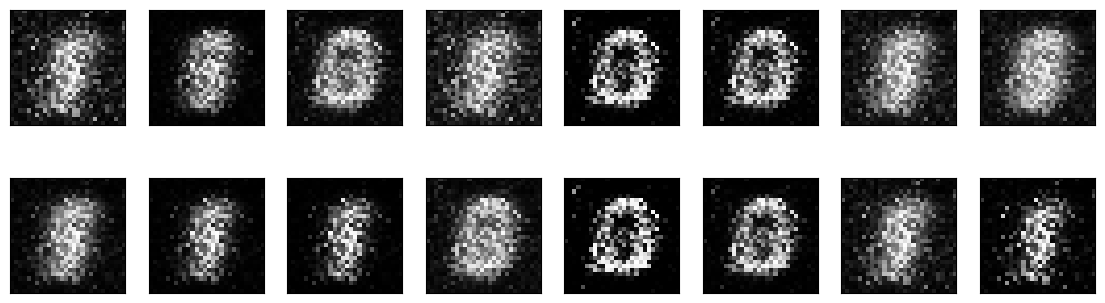

2025-05-22 20:20:27 | Epoch [6/10] | Batch 0/469 | d_loss: 0.5989 | g_loss: 3.5511
2025-05-22 20:20:28 | Epoch [6/10] | Batch 100/469 | d_loss: 0.5668 | g_loss: 3.3768
2025-05-22 20:20:28 | Epoch [6/10] | Batch 200/469 | d_loss: 0.4399 | g_loss: 5.0765
2025-05-22 20:20:29 | Epoch [6/10] | Batch 300/469 | d_loss: 0.4725 | g_loss: 5.2595
2025-05-22 20:20:29 | Epoch [6/10] | Batch 400/469 | d_loss: 0.4413 | g_loss: 4.6301


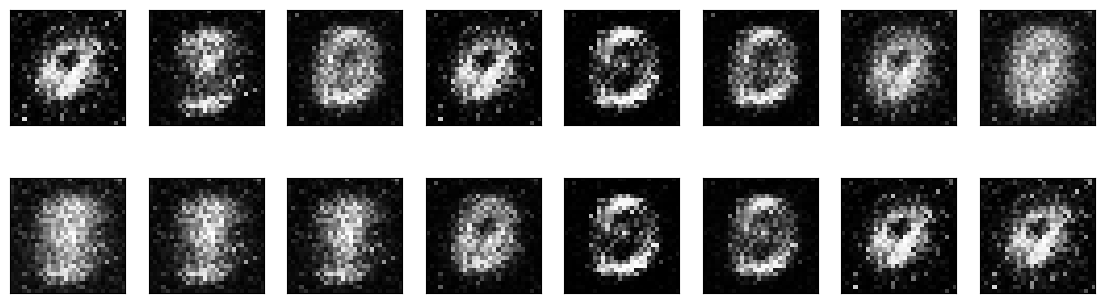

2025-05-22 20:20:31 | Epoch [7/10] | Batch 0/469 | d_loss: 0.5193 | g_loss: 3.5959
2025-05-22 20:20:31 | Epoch [7/10] | Batch 100/469 | d_loss: 0.6157 | g_loss: 4.0157
2025-05-22 20:20:32 | Epoch [7/10] | Batch 200/469 | d_loss: 0.4543 | g_loss: 5.2389
2025-05-22 20:20:32 | Epoch [7/10] | Batch 300/469 | d_loss: 0.4776 | g_loss: 4.8313
2025-05-22 20:20:33 | Epoch [7/10] | Batch 400/469 | d_loss: 0.4816 | g_loss: 4.0220


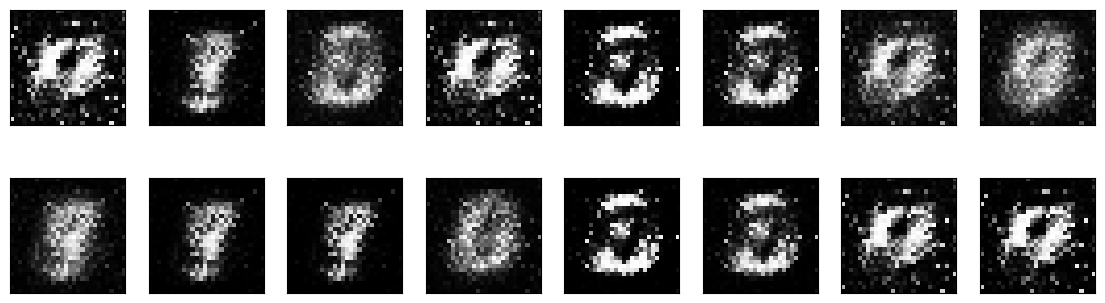

2025-05-22 20:20:35 | Epoch [8/10] | Batch 0/469 | d_loss: 0.4384 | g_loss: 4.5923
2025-05-22 20:20:35 | Epoch [8/10] | Batch 100/469 | d_loss: 0.5324 | g_loss: 4.7652
2025-05-22 20:20:35 | Epoch [8/10] | Batch 200/469 | d_loss: 0.4673 | g_loss: 5.4258
2025-05-22 20:20:36 | Epoch [8/10] | Batch 300/469 | d_loss: 0.6253 | g_loss: 4.6199
2025-05-22 20:20:36 | Epoch [8/10] | Batch 400/469 | d_loss: 0.5084 | g_loss: 4.0144


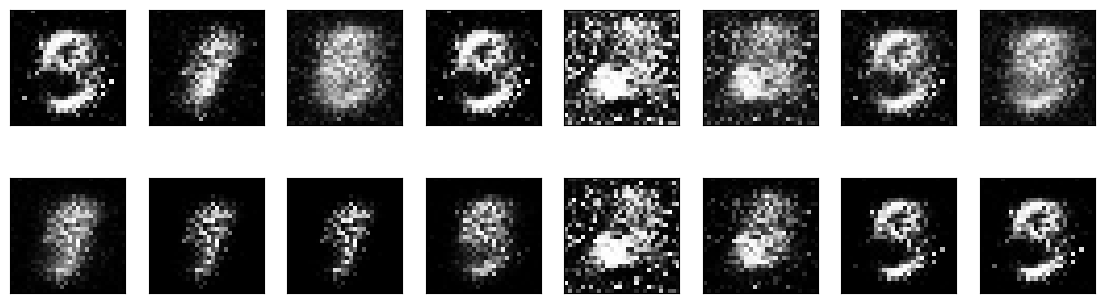

2025-05-22 20:20:38 | Epoch [9/10] | Batch 0/469 | d_loss: 0.5861 | g_loss: 3.3668
2025-05-22 20:20:39 | Epoch [9/10] | Batch 100/469 | d_loss: 0.6215 | g_loss: 3.4396
2025-05-22 20:20:39 | Epoch [9/10] | Batch 200/469 | d_loss: 0.4973 | g_loss: 4.8255
2025-05-22 20:20:39 | Epoch [9/10] | Batch 300/469 | d_loss: 0.5641 | g_loss: 3.4794
2025-05-22 20:20:40 | Epoch [9/10] | Batch 400/469 | d_loss: 0.6197 | g_loss: 3.6771


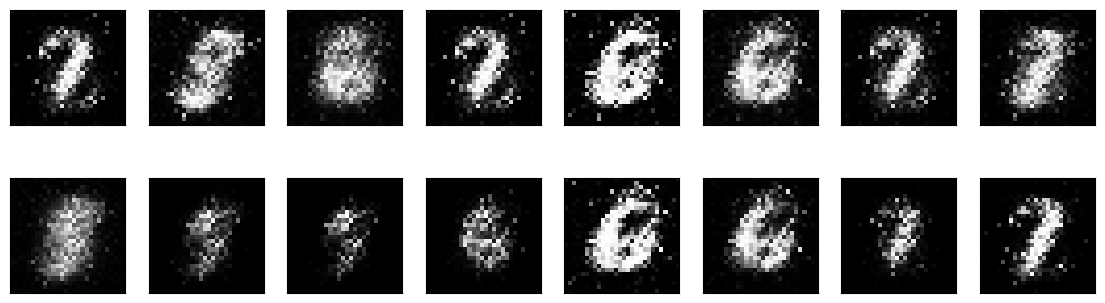

2025-05-22 20:20:42 | Epoch [10/10] | Batch 0/469 | d_loss: 0.6618 | g_loss: 3.9315
2025-05-22 20:20:42 | Epoch [10/10] | Batch 100/469 | d_loss: 0.6027 | g_loss: 4.1372
2025-05-22 20:20:43 | Epoch [10/10] | Batch 200/469 | d_loss: 0.6226 | g_loss: 4.8651
2025-05-22 20:20:43 | Epoch [10/10] | Batch 300/469 | d_loss: 0.6104 | g_loss: 3.1471
2025-05-22 20:20:43 | Epoch [10/10] | Batch 400/469 | d_loss: 0.5729 | g_loss: 3.5023


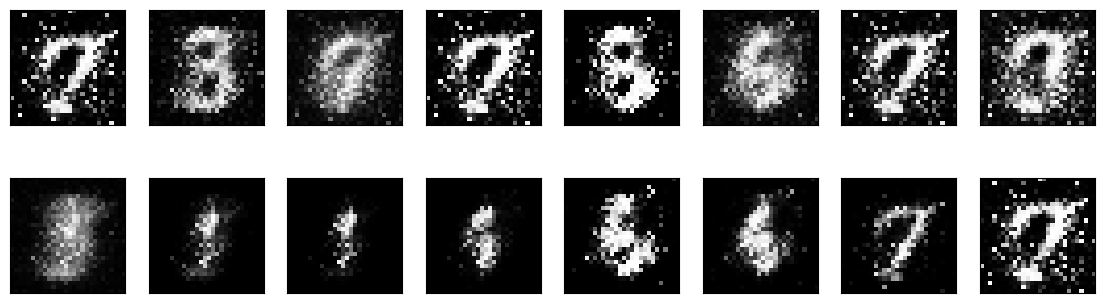

In [12]:
# training hyperparams
num_epochs = 10

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 100

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{num_epochs}] | Batch {batch_i}/{len(train_loader)} | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}')
    
            ## AFTER EACH EPOCH##
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    view_samples(-1, samples)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

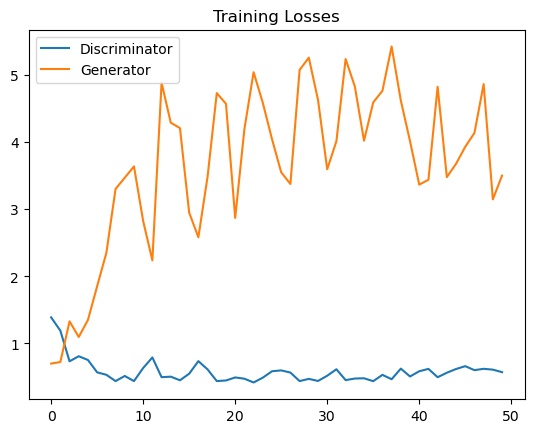

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

plt.show()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [14]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

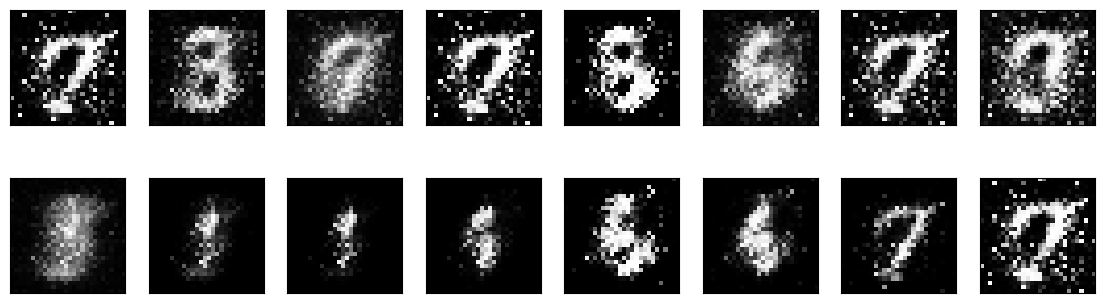

In [15]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

In [16]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

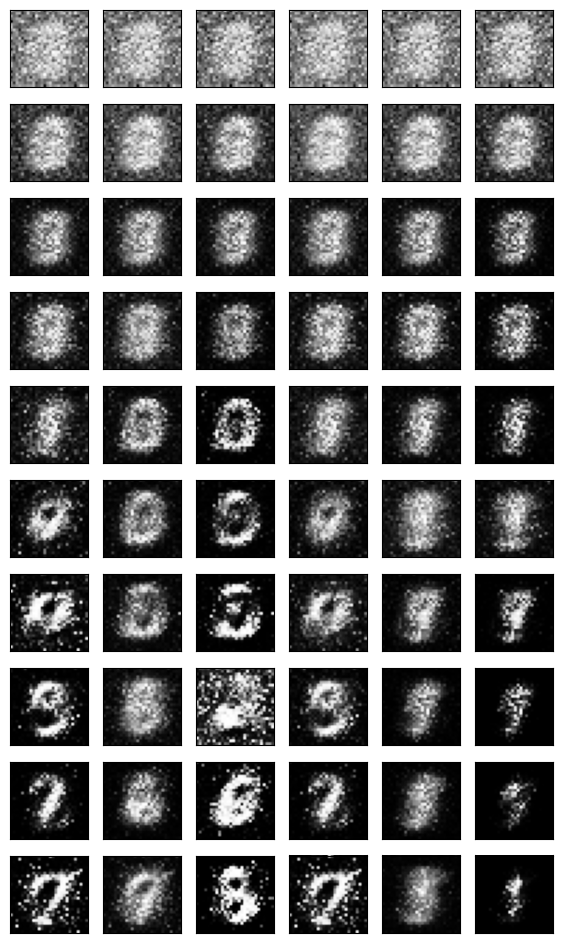

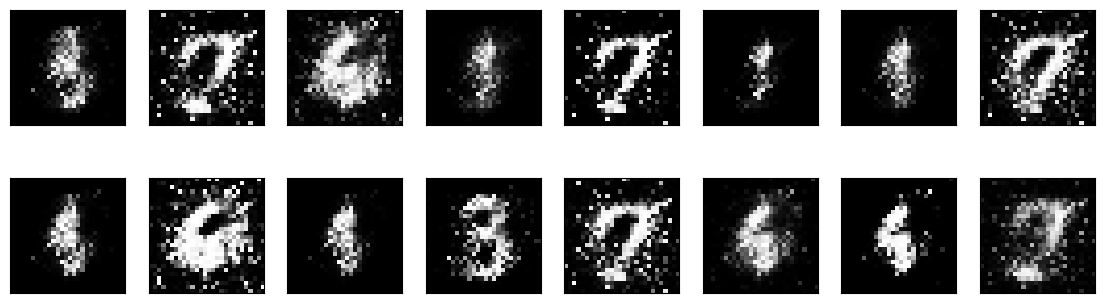

In [17]:
# randomly generated, new latent vectors
sample_size = 16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])